In [37]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline                          
sns.set(color_codes=True)                   

In [38]:
import os
# excel_file_path = os.path.join(os.getcwd(), 'price_history.xlsx')
# df_xlsx = pd.read_excel(excel_file_path)
csv_file_path = os.path.join(os.getcwd(), 'data_csv_file.csv')
# df_xlsx.to_csv(csv_file_path, index=False)
df = pd.read_csv(csv_file_path)
print(df.head())

         Exchange Date    Close    Net      %Chg     Open      Low     High
0  2024-04-22 00:00:00  1067.81   5.08  0.004780  1063.63  1061.95  1069.61
1  2024-04-19 00:00:00  1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51
2  2024-04-18 00:00:00  1077.89   3.02  0.002810  1076.24  1072.81  1083.88
3  2024-04-17 00:00:00  1074.87   3.81  0.003557  1070.80  1070.46  1076.86
4  2024-04-16 00:00:00  1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64


In [39]:
df['Exchange Date'] = pd.to_datetime(df['Exchange Date'], errors='coerce') # Transforming data in timestamps.
df = df.dropna(subset=['Exchange Date']) # Removing invalid dates. (such as 30th feb)

In [40]:
print(df.shape)

(941, 7)


In [41]:
duplicate_rows_df = df[df.duplicated()] 
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (1, 7)


In [42]:
df = df.drop_duplicates(keep='last') # Removing duplicate rows.
print(df.shape)

(940, 7)


!Check if any dates are missing below!. // (should check if weekdays are included)

In [43]:
daily_data = pd.DataFrame(pd.date_range(start=df['Exchange Date'].min(),end=df['Exchange Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

,Date
count,1315
mean,2022-07-05 00:00:00
min,2020-09-16 00:00:00
25%,2021-08-10 12:00:00
50%,2022-07-05 00:00:00
75%,2023-05-29 12:00:00
max,2024-04-22 00:00:00


# EDA

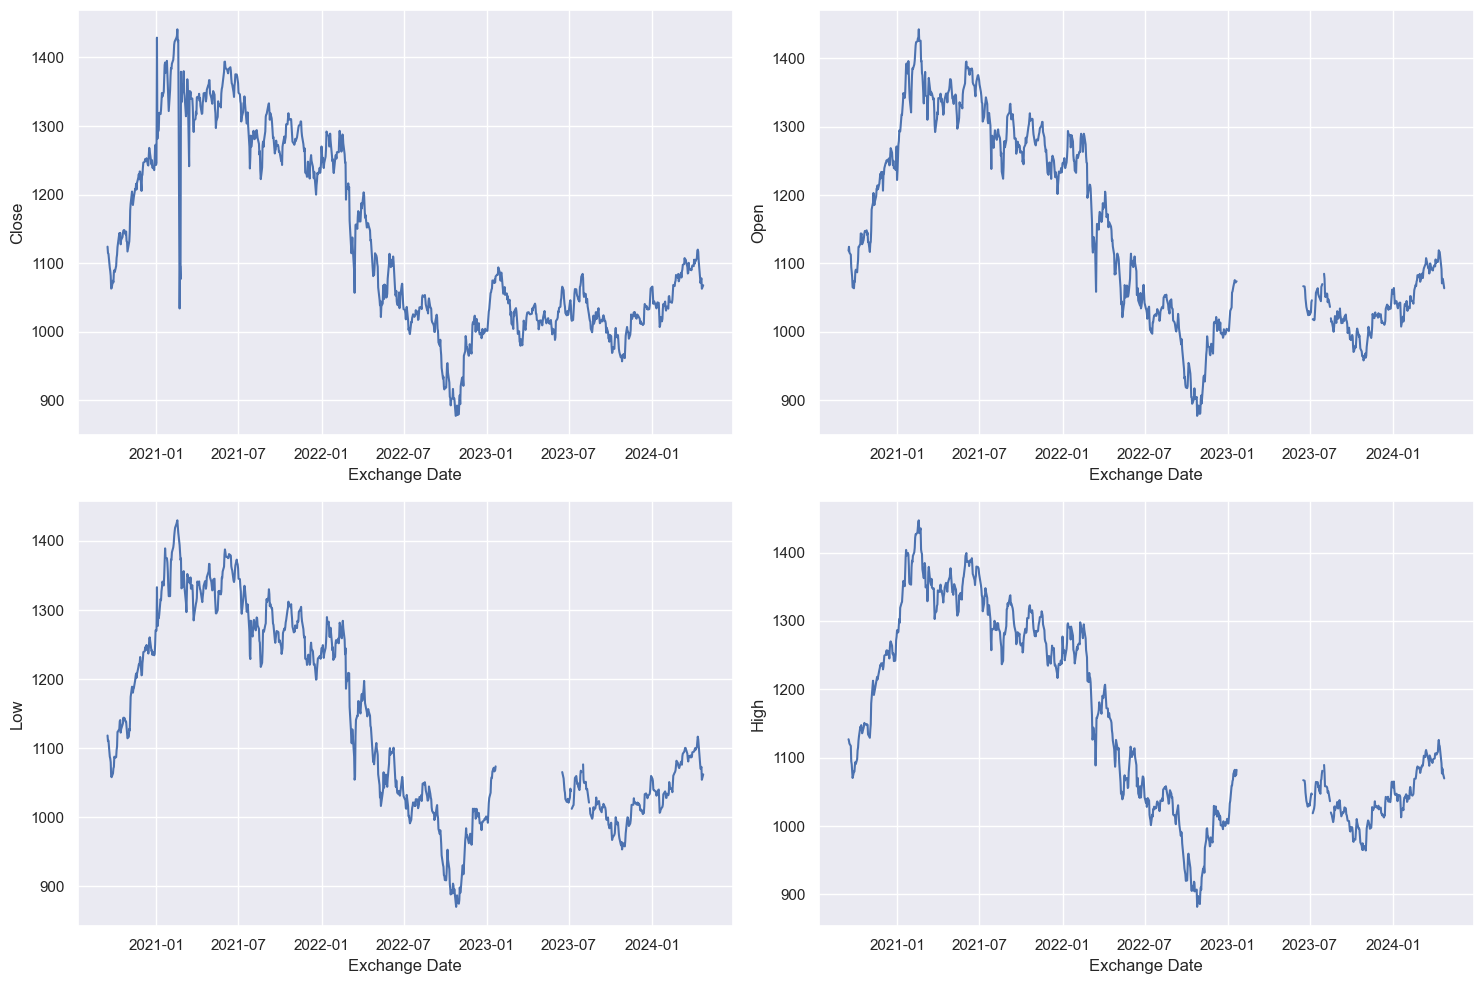

In [44]:
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.plot(df['Exchange Date'], df[column])
    plt.xlabel('Exchange Date')
    plt.ylabel(column)  
plt.tight_layout()  
plt.show()

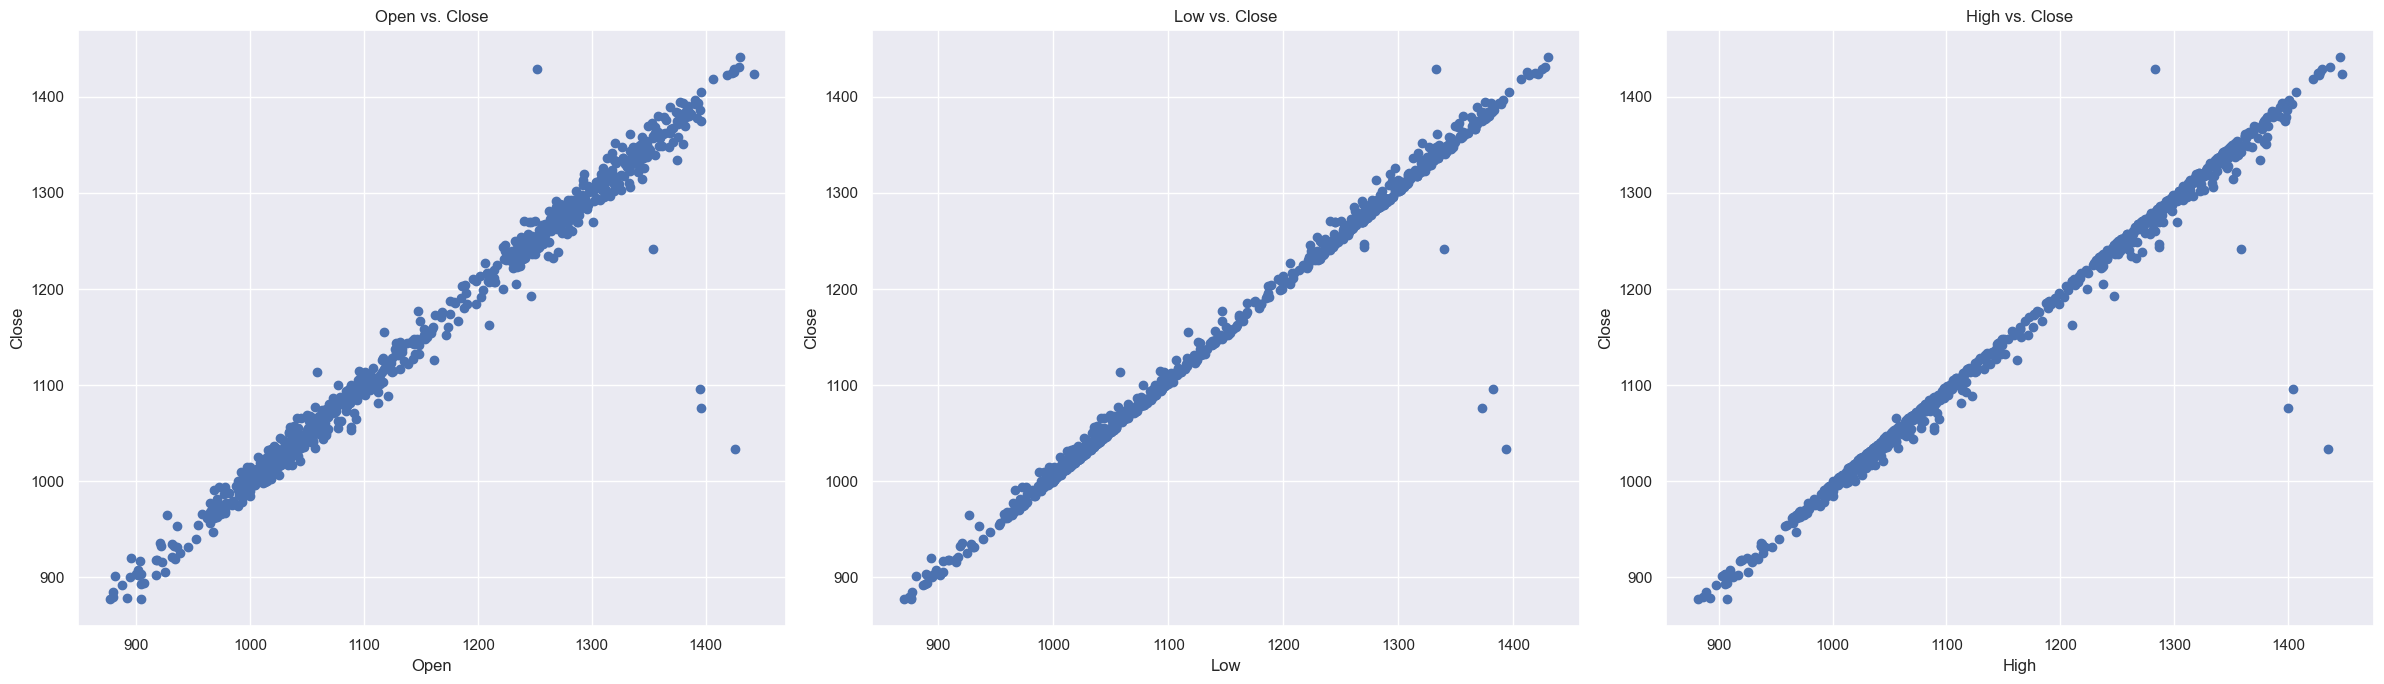

In [45]:
columns_to_plot = ['Open', 'Low', 'High']

# Create a figure and subplots using a for loop
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(24, 7))

for col, ax in zip(columns_to_plot, axes):
    ax.scatter(df[col], df['Close'])
    ax.set_xlabel(col)
    ax.set_ylabel('Close')
    ax.set_title(f'{col} vs. Close')

plt.tight_layout()
plt.show()

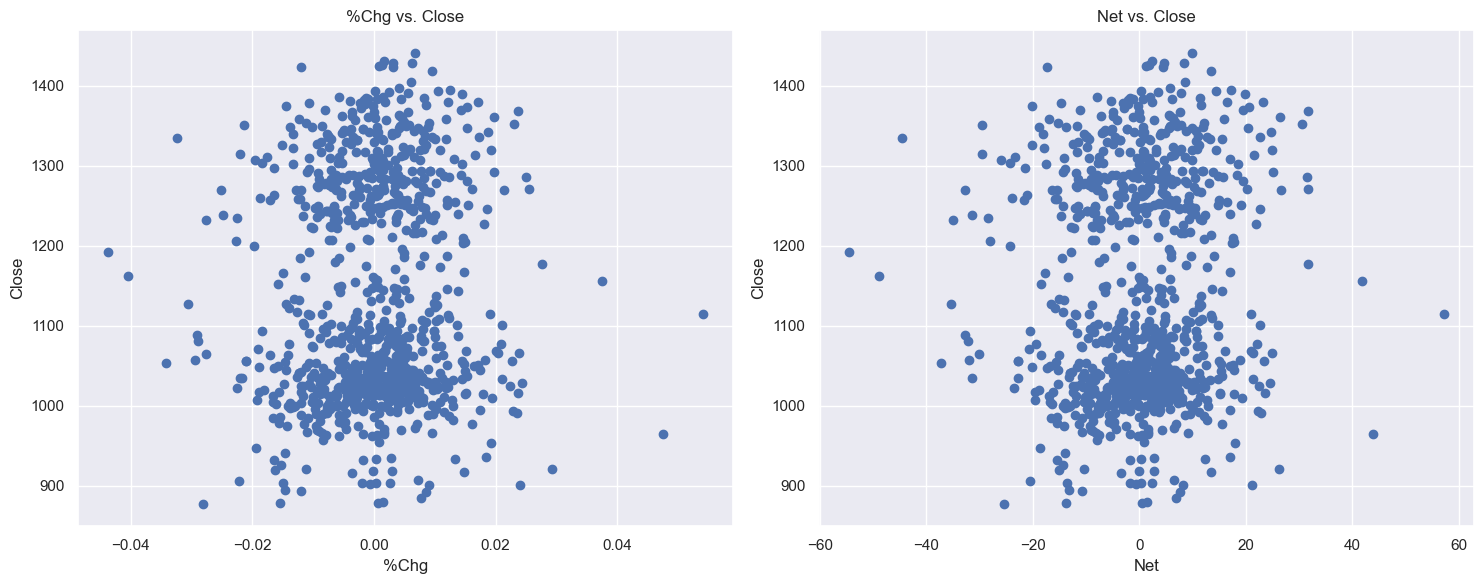

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.scatter(df['%Chg'], df['Close'])
ax1.set_xlabel('%Chg')
ax1.set_ylabel('Close')
ax1.set_title('%Chg vs. Close') 

ax2.scatter(df['Net'], df['Close'])
ax2.set_xlabel('Net')
ax2.set_ylabel('Close')
ax2.set_title('Net vs. Close') 

plt.tight_layout()
plt.show()

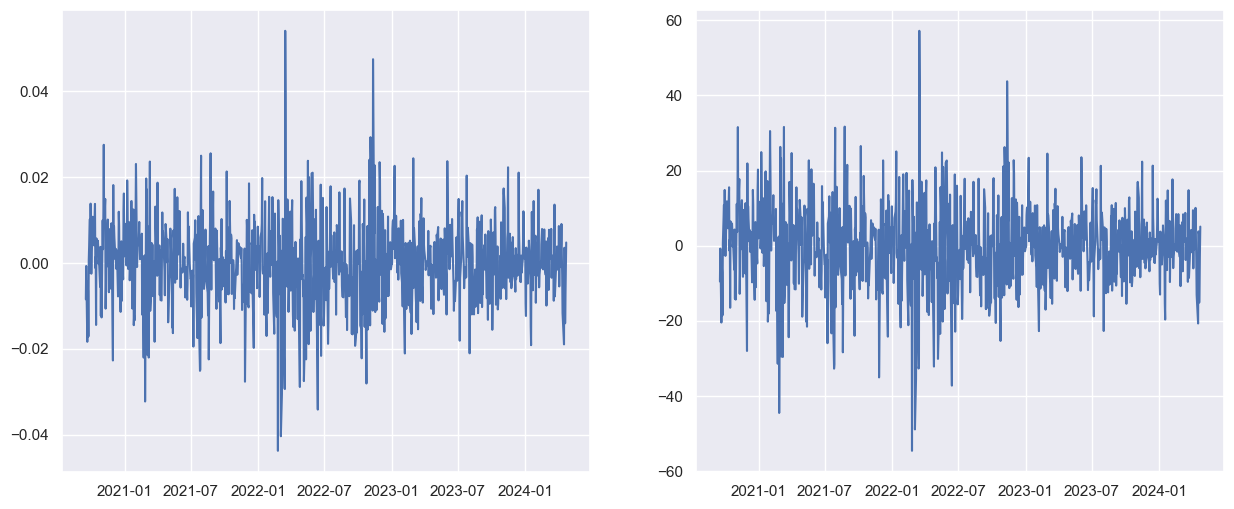

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(df['Exchange Date'], df['%Chg'])
ax2.plot(df['Exchange Date'], df['Net'])
plt.show()

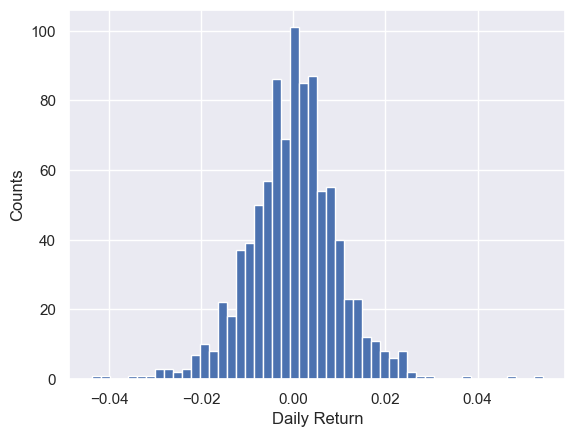

In [48]:
plt.hist(df['%Chg'], bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.show()

## Outliers

Visualizing the outliers:

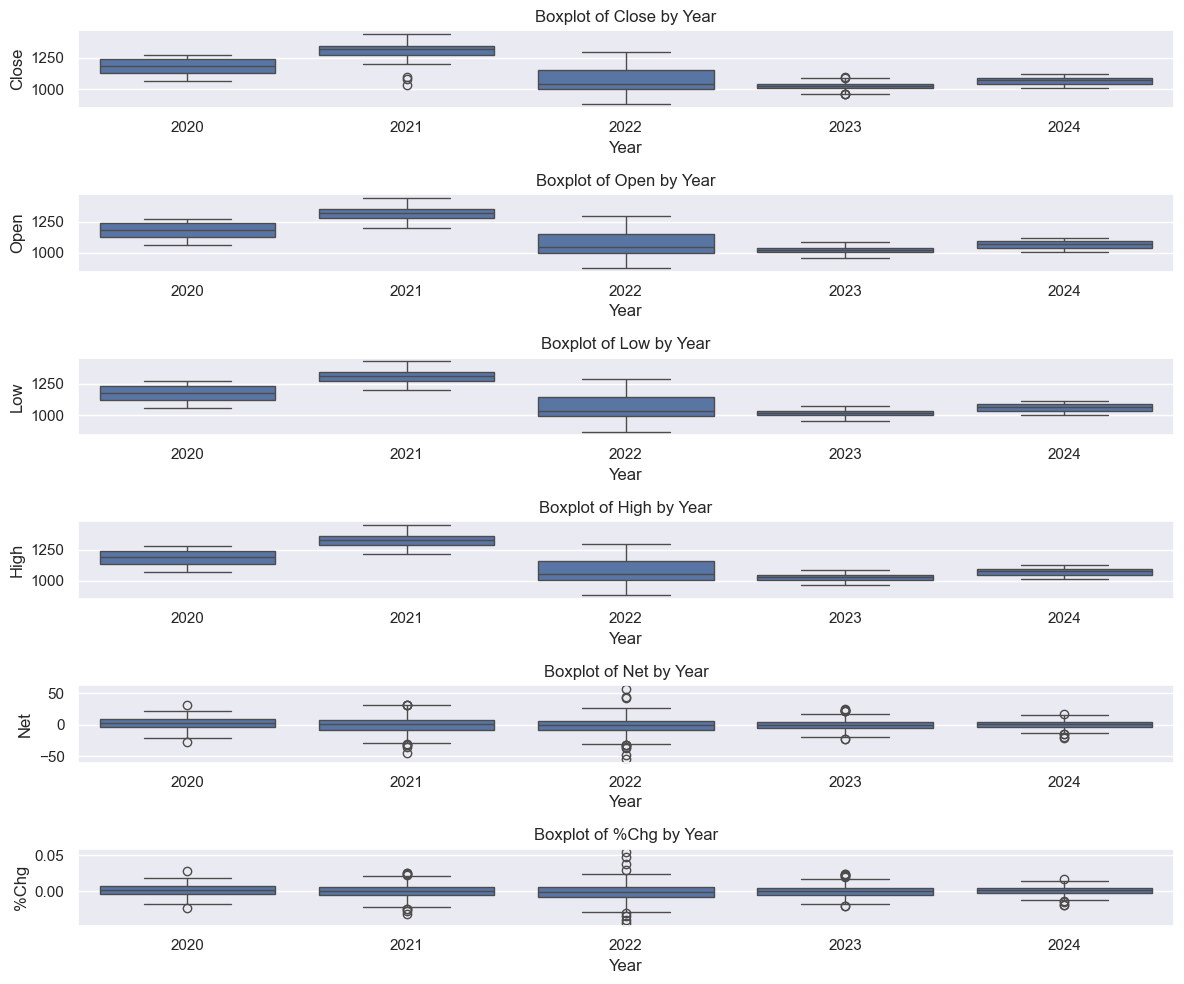

In [49]:
df['Year'] = df['Exchange Date'].dt.year
years = df['Year'].unique()
columns_to_plot = ['Close', 'Open', 'Low', 'High', 'Net', '%Chg']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 10))

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.set_title(f"Boxplot of {column} by Year")
    sns.boxplot(x="Year", y=column, data=df, ax=ax)

plt.tight_layout()
plt.show()

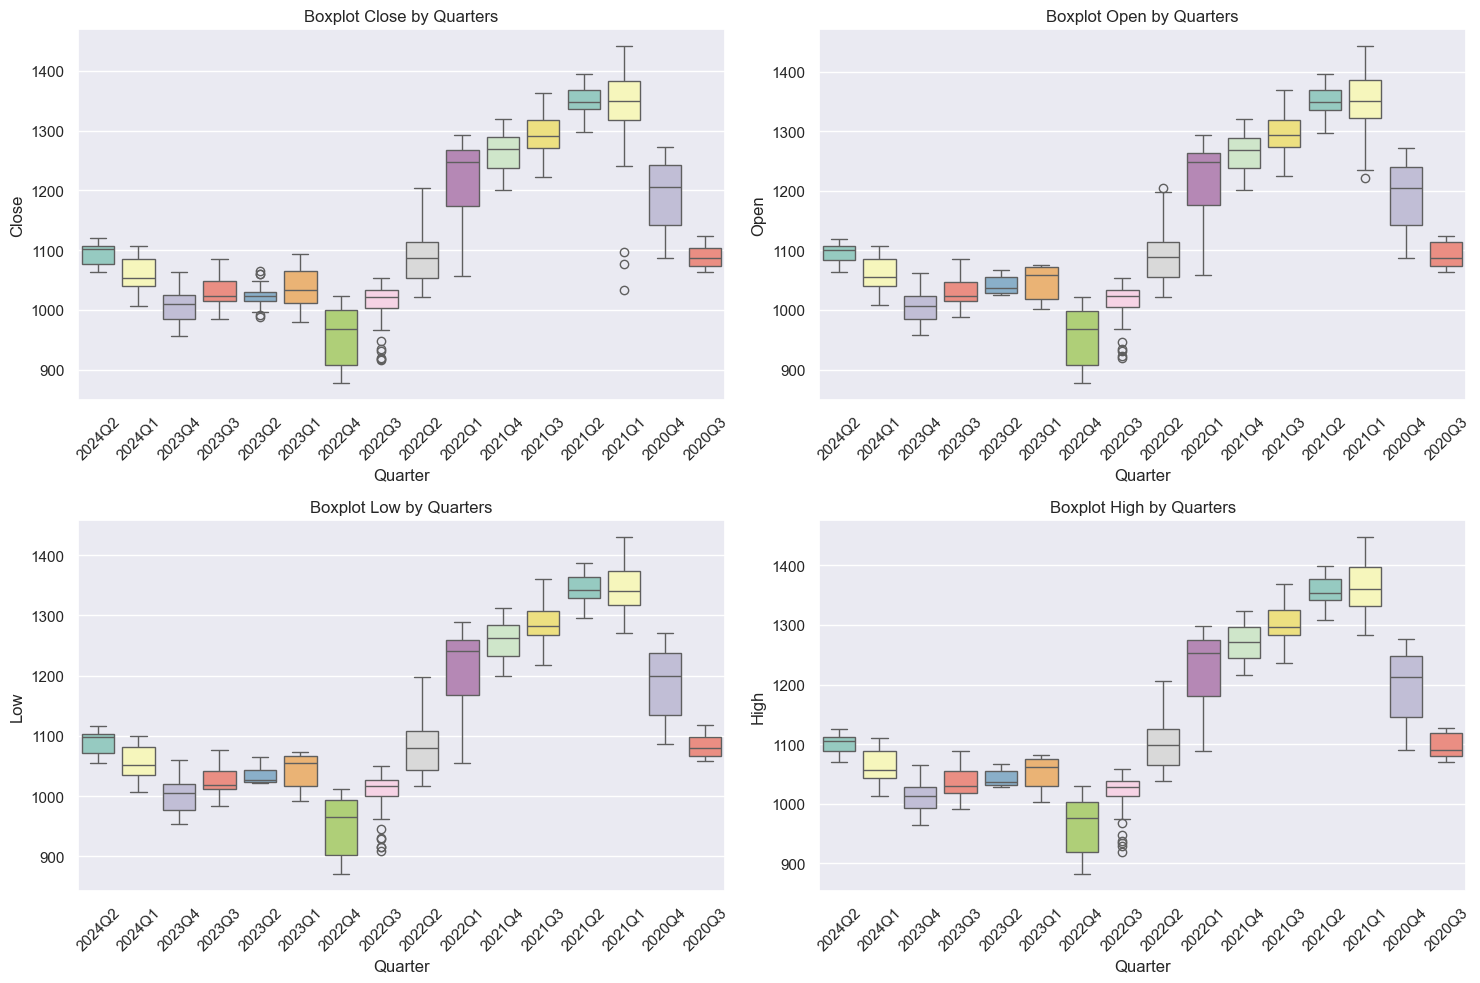

In [50]:
df['Quarter'] = df['Exchange Date'].dt.to_period('Q')
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Quarter', y=column, data=df, palette='Set3', hue = 'Quarter')
    plt.title(f'Boxplot {column} by Quarters')
    plt.xlabel('Quarter')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Interquartile Range (IQR) method

In [51]:
df.set_index('Exchange Date', inplace=True)
print(df.head())

                 Close    Net      %Chg     Open      Low     High  Year  \
Exchange Date                                                              
2024-04-22     1067.81   5.08  0.004780  1063.63  1061.95  1069.61  2024   
2024-04-19     1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51  2024   
2024-04-18     1077.89   3.02  0.002810  1076.24  1072.81  1083.88  2024   
2024-04-17     1074.87   3.81  0.003557  1070.80  1070.46  1076.86  2024   
2024-04-16     1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64  2024   

              Quarter  
Exchange Date          
2024-04-22     2024Q2  
2024-04-19     2024Q2  
2024-04-18     2024Q2  
2024-04-17     2024Q2  
2024-04-16     2024Q2  


In [52]:
df = df.apply(pd.to_numeric, errors='coerce')

Q1 = df.quantile(0.25).astype(float)
Q3 = df.quantile(0.75).astype(float)
IQR = Q3 - Q1

outliers_mask = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
outliers = df[outliers_mask]
print(len(outliers))

37


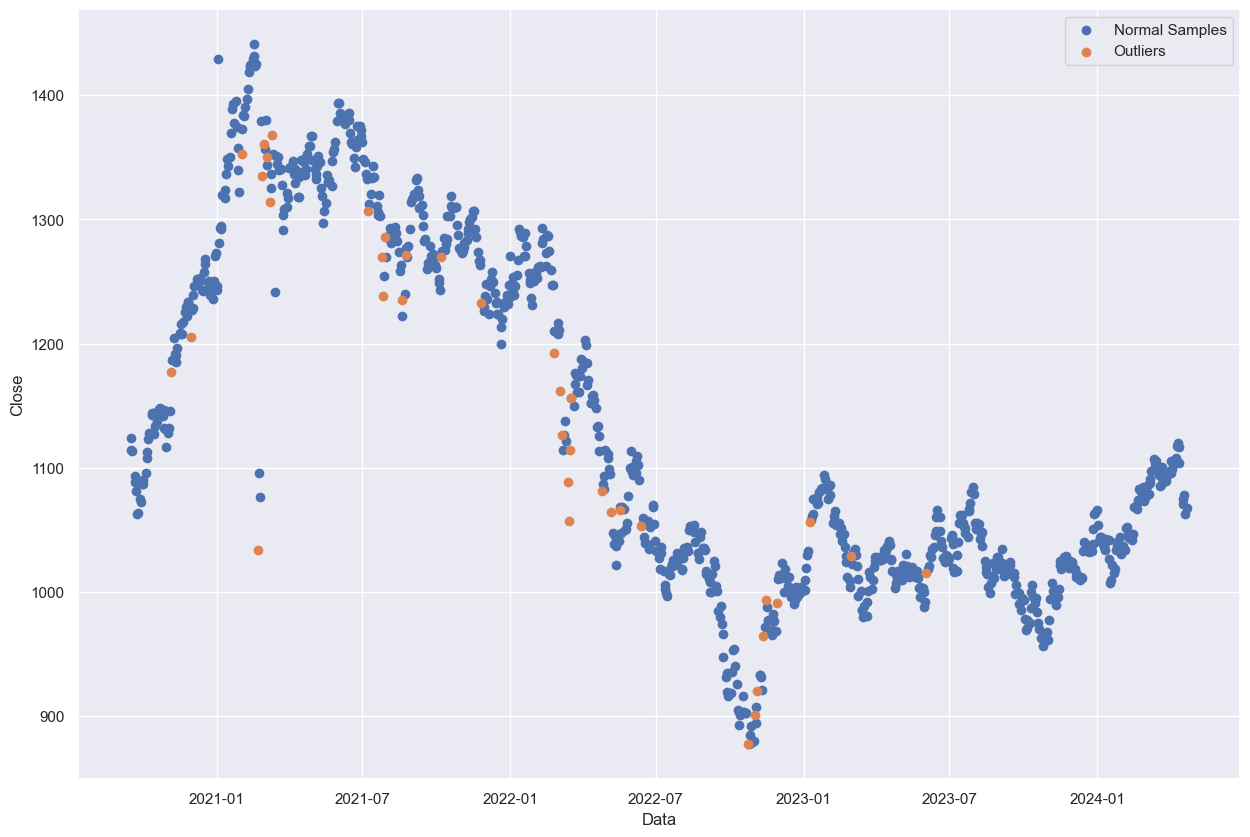

In [53]:
normal_df = df[~outliers_mask]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

## Robust z-score method (MAD - Median absolute deviation)

Not expected to perform well because the data is not normally distributed.

<Axes: xlabel='Close', ylabel='Density'>

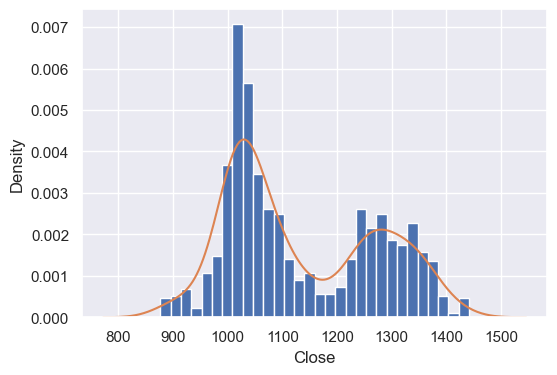

In [54]:
plt.figure(figsize=(6, 4))
plt.hist(df['Close'], bins=30, density=True)

sns.kdeplot(df['Close'])

Apply z-score for the entire dataset

In [55]:
from scipy.stats import median_abs_deviation
mad = median_abs_deviation(df['Close'])
median = np.median(df['Close'])
mean = np.mean(df['Close'])

def compute_robust_z_score(x):
  return 0.6745*(x - median)/mad

z_scores = df['Close'].apply(compute_robust_z_score)
lower_threshold = -1.5
upper_threshold = 2.5
outliers_mask = (z_scores < lower_threshold) | (z_scores > upper_threshold)
outliers = df[outliers_mask]

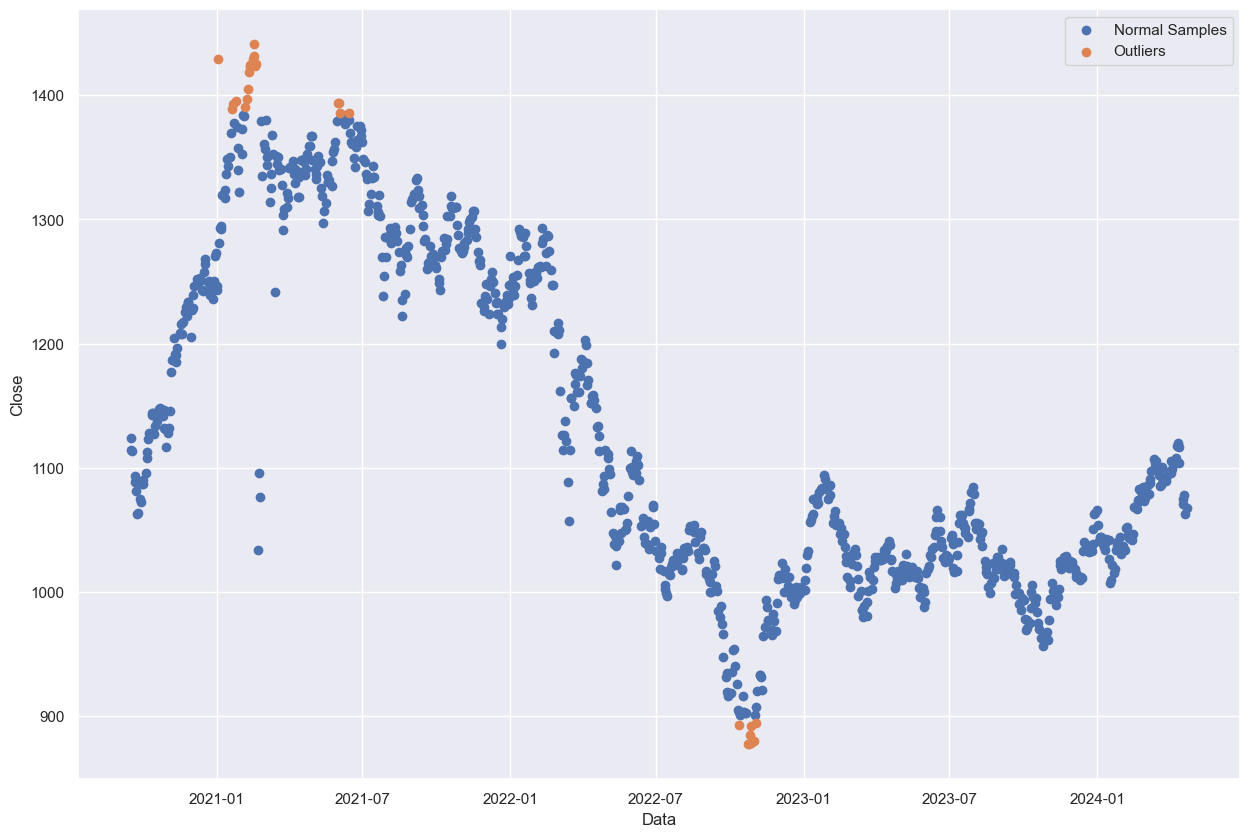

In [56]:
normal_df = df[~outliers_mask]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

Apply z-score for every quarter

In [76]:
df.index = pd.to_datetime(df.index)
df['Month'] = df.index.to_period('M')
grouped = df.groupby('Month')

outliers_list = []
normal_list = []

for month, data in grouped:
    mad = median_abs_deviation(data['Close'])
    median = np.median(data['Close'])
    
    z_scores = 0.6745 * (data['Close'] - median) / mad
    
    lower_threshold = -1.5
    upper_threshold = 2.5
    
    outliers_mask = (z_scores < lower_threshold) | (z_scores > upper_threshold)

    outliers_list.append(data[outliers_mask])
    normal_list.append(data[~outliers_mask])

outliers = pd.concat(outliers_list)
normal_df = pd.concat(normal_list)

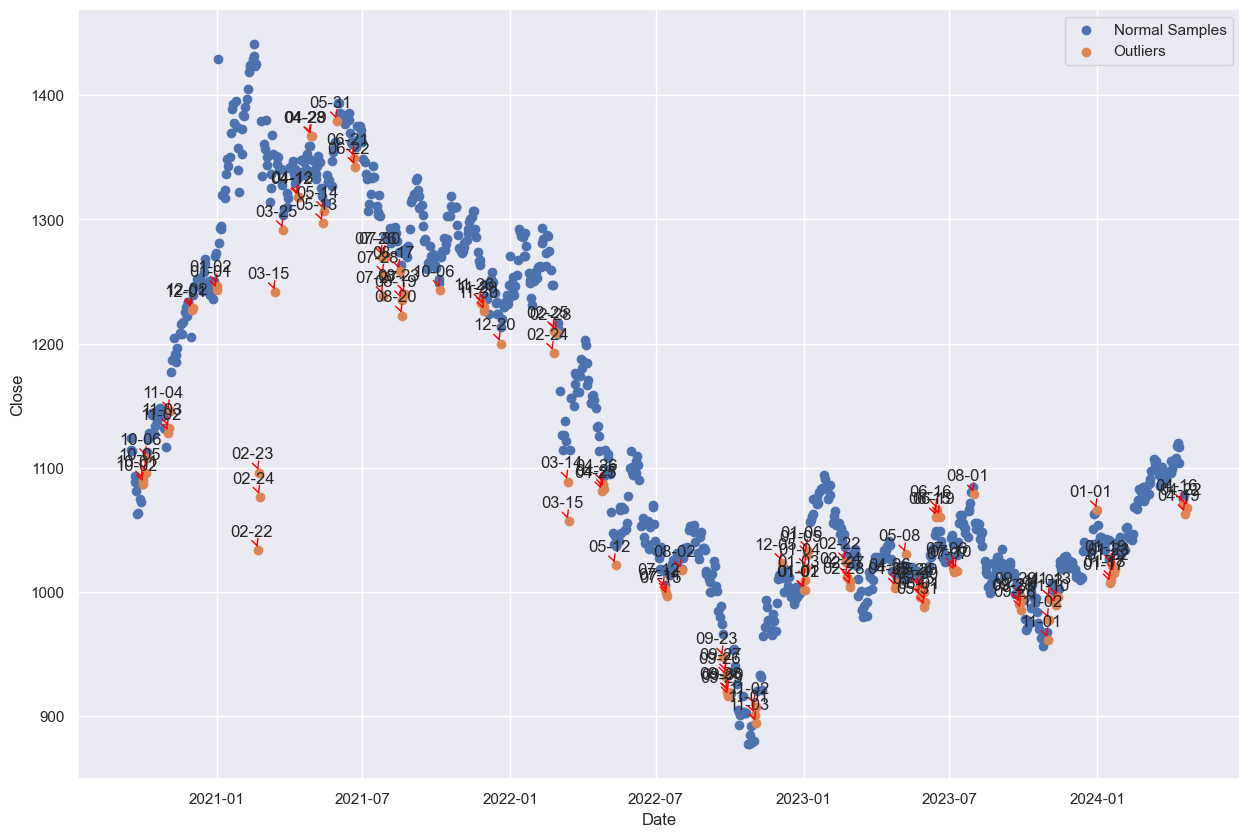

In [83]:
plt.figure(figsize=(15, 10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
for idx in outliers.index:
    plt.annotate(f"{idx.strftime('%m-%d')}", xy=(idx, outliers.loc[idx, 'Close']), xytext=(-20, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()

## Local Outlier Factor (LOF) method

In [57]:
df.head()
print(df.isna().sum())
df_relevant_columns = df[['Close']]
df_relevant_columns.head()

Close        0
Net          1
%Chg         1
Open       107
Low        107
High       107
Year         0
Quarter    940
dtype: int64


,Close
Exchange Date,
2024-04-22,1067.81
2024-04-19,1062.73
2024-04-18,1077.89
2024-04-17,1074.87
2024-04-16,1071.06


In [58]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1) # default values, play with them
y_pred = lof.fit_predict(df_relevant_columns)
scores = lof.negative_outlier_factor_
print("Number of outliers detected: {}".format(np.sum(y_pred == -1)))
print("Number of normal samples detected: {}".format(np.sum(y_pred == 1)))

Number of outliers detected: 94
Number of normal samples detected: 846


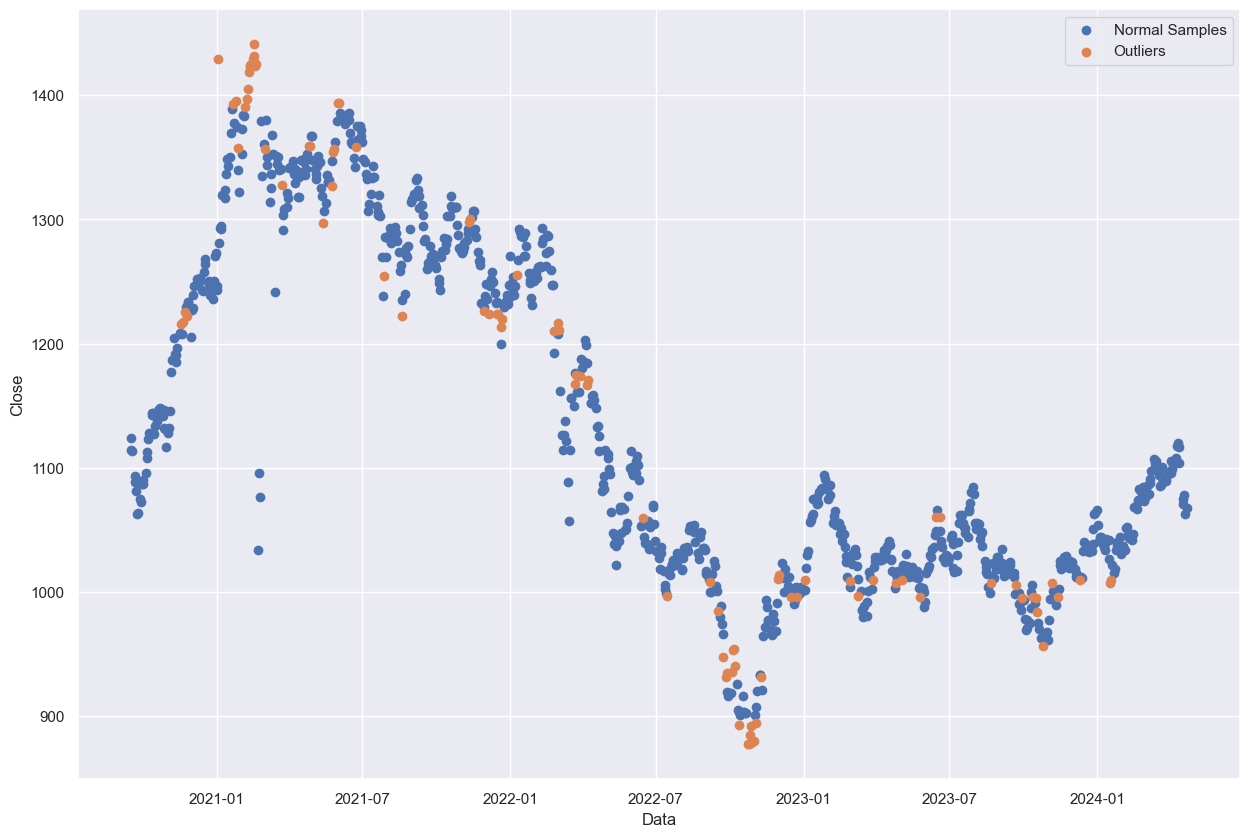

In [59]:
normal_df = df_relevant_columns[y_pred > 0]
outliers = df_relevant_columns[y_pred < 0]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

Nu inteleg de ce aici nu detecteaza punctele din 2021-02 ca fiind outliers ptc densitatea vecinilor lor e scazuta => izolate => outliers.

## Isolation Forest

to do: sa detectez pe ani/trimestre, nu pe intreg setul de date, desi nu stiu daca merita, are rezultate similare cu MAD, pare ca nu se preteaza cu distributia datelor noastre

In [60]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators = 100, contamination = 0.03, max_samples = 'auto')
y_pred = iforest.fit_predict(df_relevant_columns.values)
print("Number of outliers detected: {}".format(np.sum(y_pred == -1)))
print("Number of normal samples detected: {}".format(y_pred[y_pred > 0].sum()))

Number of outliers detected: 29
Number of normal samples detected: 911


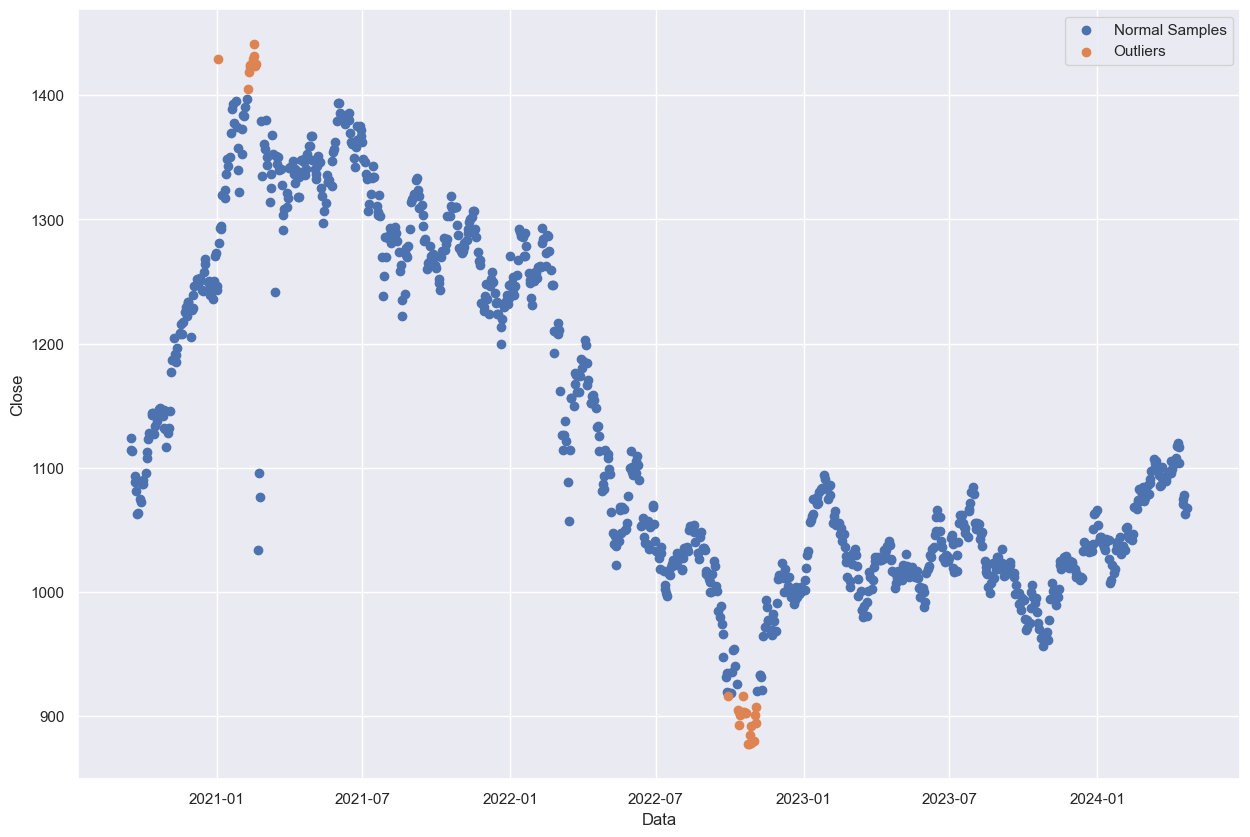

In [61]:
normal_df = df_relevant_columns[y_pred > 0]
outliers = df_relevant_columns[y_pred < 0]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

Mai sunt si Mahalanobis distance, PCA methods..
to do: ACF, PACF plots

## Corelation matrix

,Close,Net,%Chg,Open,Low,High,Year,Quarter
Close,1.000000,0.057873,0.054537,0.984914,0.988776,0.987114,-0.652430,NaN
Net,0.057873,1.000000,0.992462,-0.035806,0.011220,0.004282,-0.017420,NaN
%Chg,0.054537,0.992462,1.000000,-0.036541,0.009363,0.003908,-0.015889,NaN
Open,0.984914,-0.035806,-0.036541,1.000000,0.998146,0.998621,-0.623040,NaN
Low,0.988776,0.011220,0.009363,0.998146,1.000000,0.998551,-0.621041,NaN
High,0.987114,0.004282,0.003908,0.998621,0.998551,1.000000,-0.626664,NaN
Year,-0.652430,-0.017420,-0.015889,-0.623040,-0.621041,-0.626664,1.000000,NaN
Quarter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


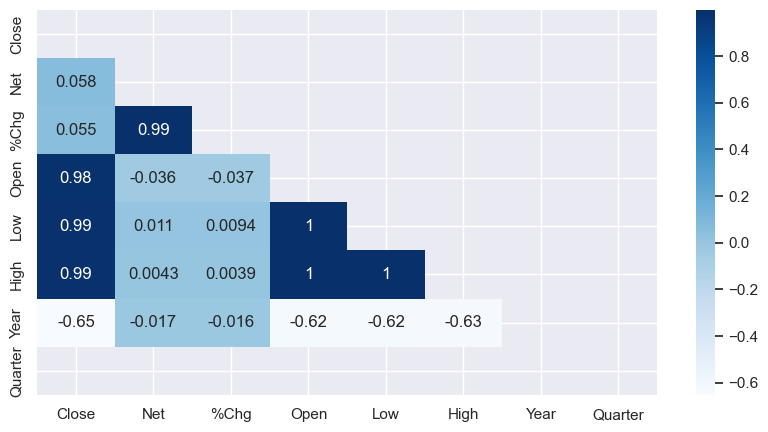

In [62]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,5))
sns.heatmap(corr, cmap="Blues", annot=True, mask = mask)
corr

# Missing Values

In [63]:
# linear interpolation
df_linear_interpolation = df.copy(deep=True)
df_linear_interpolation['Open'] = df_linear_interpolation['Open'].interpolate(method='linear')

# polynomail interpolation
df_polynomial_interpolation = df.copy(deep=True)
df_polynomial_interpolation['Open'] = df_polynomial_interpolation['Open'].interpolate(method='polynomial', order=2)

# pad interpolation
df_pad_interpolation = df.copy(deep=True)
df_pad_interpolation['Open'] = df_pad_interpolation['Open'].ffill()

## Cubic Spline

<div style="color: #ff365e; font-weight: bold;">
    WARNING
</div>

Din nu stiu ce cauza, la cubic spline daca nu rulezi si graficele plotate de Ana mai inainte, mereu o sa aiba anomalia aia unde se strica varful de la 2023-07 cu 1100

In [64]:
from scipy.interpolate import CubicSpline
df_cublicSpline = df.copy(deep=True)

# Extracting non-missing values
x = df['Exchange Date'][df['Open'].notnull()][::-1]
y = df['Open'].dropna()[::-1]

# Perform cubic spline interpolation
cs = CubicSpline(x, y)
interpolated_values = cs(df['Exchange Date'])
# indices of missing values that were filled 
filled_indices = df['Open'].isnull()

# noise function to add on top of interpolation
noise_level = 5
noise = np.random.normal(scale=noise_level, size=len(df_cublicSpline['Open']))
# convoluting with a gaussian distribution to smooth out the noise
smooth_noise = np.convolve(noise, np.ones(20)/2, mode='same')

# adding the noise to the interpolation
interpolated_values[filled_indices] += smooth_noise[filled_indices]

df_cublicSpline['Open'] = interpolated_values

KeyError: 'Exchange Date'

In [ ]:
plt.plot(df_cublicSpline['Exchange Date'], df_cublicSpline['Open'])
plt.xlabel('Exchange Date')
plt.ylabel('Open')
plt.show()

: 

## All Interpolations

In [ ]:
df_interpolations = df.copy(deep=True)

interpolations = [
    ("linear", df_linear_interpolation['Open'].interpolate(method='linear')),
    ("polynomial_order2", df_polynomial_interpolation['Open'].interpolate(method='polynomial', order=2)),
    ("pad_ffill", df_pad_interpolation['Open'].ffill()),
    ("cubicSpline_withNoise", df_cublicSpline['Open'])
]

plt.figure(figsize=(15, 10))
for i, interpolation in enumerate(interpolations, 1):
    plt.subplot(2, 2, i)
    df_interpolations[interpolation[0]] = interpolation[1]
    plt.plot(df_interpolations['Exchange Date'], df_interpolations[interpolation[0]])
    plt.xlabel('Exchange Date')
    plt.ylabel(interpolation[0])
plt.tight_layout()
plt.show()

: 

# Checking NET values 

In [ ]:
errors = []
for i in range(1, len(df)):
    if df.iloc[i-1]['Close'] - df.iloc[i-1]['Net'] != df.iloc[i]['Close']:
        errors.append((df.iloc[i-1], df.iloc[i]))
        
print(f"Numar errori la NET: {len(errors)}")
# for error in errors:
#     print(*error, sep="\n", end="\n\n")

: 

### Duplicate value with different date

<div style="color: #9538ff; font-weight: bold;">
    IMPORTANT
</div>


In [ ]:
print(df[df['Exchange Date'] == '2023-01-02'])
print(df[df['Exchange Date'] == '2023-01-01'])

: 

# Matrix for Differences

In [ ]:
columns = ["Exchange Date", "Close", "Net", "%Chg", "Open", "Low", "High"]
difference_matrix = []

for i in range(len(df)):
    try:
        row1 = df.loc[i, columns].values
        row2_diff = (df.loc[:, columns] == row1).sum(axis=1)
        difference_matrix.append(row2_diff)
    except:
        difference_matrix.append(0)
        
# print(difference_matrix)

: 

In [ ]:
indices_of_common_rows = []

for i, row in enumerate(difference_matrix):
    if i in [34, 35, 94, 93]:
        continue

    for j in range(len(row)):
        if j in [34, 35, 94, 93]:
            continue

        if i != j and row[j] != 0:
            indices_of_common_rows.append((i, j, row[j]))

# print(indices_of_common_rows)

: 

In [ ]:
filtered_indices = [ind for ind in indices_of_common_rows if ind[2] != 1]
print(filtered_indices)

: 

### In data_csv_file.csv

107,108 - 3 common values 
341,342 - 6 common values
865,866 - 2 common values

# Checking %CHG values

In [ ]:
chg_errors = []
epsilon = 0.015

for i in range(1, len(df)):
    percentage = (df.iloc[i-1]['Close'] - df.iloc[i]['Close']) / df.iloc[i-1]['Close']
    
    if not (df.iloc[i - 1]['%Chg'] - epsilon <= percentage <= df.iloc[i - 1]['%Chg'] + epsilon):
        chg_errors.append((df.iloc[i-1], df.iloc[i]))

print(f"Numar errori la %CHG: {len(chg_errors)}")
# for error in chg_errors:
#     print(*error, sep="\n", end="\n\n")

: 